In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
df=pd.read_csv('framingham.csv')

In [4]:
import pandas_profiling as pp

In [ ]:
pp.ProfileReport(df)

In [4]:
df = df.drop(['education'], axis=1) 
# Since education is not a necessay feature for the heart attack prediction, it can be removed

In [5]:
df = df.drop(['currentSmoker'], axis=1) 
# Since cigsPerDay is highly correlated with currentSmoker and cigsPerDay=0 means CurrentSmoker = 0, thus this column can be removed

In [6]:
df=df.dropna()

In [8]:
df.TenYearCHD.value_counts()
# This dataset is dominated by the patients who have low risk of the CHD.

0    3179
1     572
Name: TenYearCHD, dtype: int64

In [14]:
x = df.iloc[:,0:13]  #independent columns
y = df.iloc[:,-1]    #target column

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [16]:
from collections import Counter
print(y_test.unique())
Counter(y_train)

[0 1]


Counter({0: 2532, 1: 468})

Class 0: 3179
Class 1: 572
Proportion: 5.56 : 1


C:\Users\Cathy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


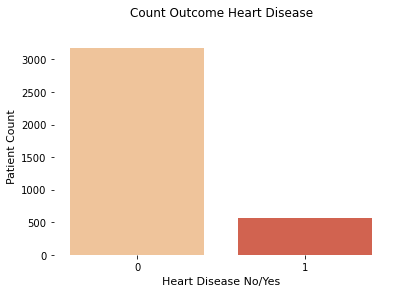

In [16]:
# Checking balance of outcome variable
target_count = df.TenYearCHD.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

sns.countplot(df.TenYearCHD, palette="OrRd")
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease\n')
plt.savefig('Balance Heart Disease.png')
plt.show()

Thus there is an inbalance in the dataset, for every one postive case there is 6 negative cases.

# Add only top 10 features
Dropping off the lease important features in the dataset such as BMI, prevalentStroke and Heartrate
['sysBP','glucose','age','totChol','cigsPerDay','diaBP','prevalentHyp','diabetes','BPMeds','male']

In [17]:
df_top = df

In [18]:
df_top = df_top.drop(['BMI'], axis=1)

In [19]:
df_top = df_top.drop(['prevalentStroke'], axis=1)

In [20]:
df_top = df_top.drop(['heartRate'], axis=1)

In [21]:
df_top.head()

,male,age,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,glucose,TenYearCHD
0,1,39,0.0,0.0,0,0,195.0,106.0,70.0,77.0,0
1,0,46,0.0,0.0,0,0,250.0,121.0,81.0,76.0,0
2,1,48,20.0,0.0,0,0,245.0,127.5,80.0,70.0,0
3,0,61,30.0,0.0,1,0,225.0,150.0,95.0,103.0,1
4,0,46,23.0,0.0,0,0,285.0,130.0,84.0,85.0,0


In [22]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) 

#assign scaler to column:
df_scaled = pd.DataFrame(scaler.fit_transform(df_top), columns=df_top.columns)

In [23]:
# clarify what is y and what is x label
y = df_scaled['TenYearCHD']
X = df_scaled.drop(['TenYearCHD'], axis = 1)

# divide train test: 80 % - 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# UNDERSAMPLING

0.0    600
1.0    572
Name: TenYearCHD, dtype: int64


C:\Users\Cathy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


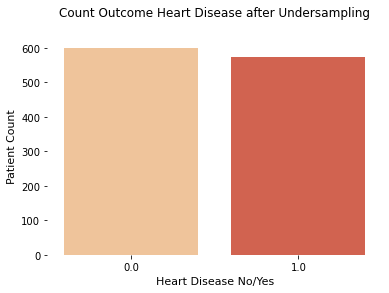

In [24]:
shuffled_df = df_scaled.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
CHD_df = shuffled_df.loc[shuffled_df['TenYearCHD'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_CHD_df = shuffled_df.loc[shuffled_df['TenYearCHD'] == 0].sample(n=600,random_state=0)

# Concatenate both dataframes again
normalized_df = pd.concat([CHD_df, non_CHD_df])

# check new class counts
print(normalized_df.TenYearCHD.value_counts())

# plot new count
sns.countplot(normalized_df.TenYearCHD, palette="OrRd")
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease after Undersampling\n')
#plt.savefig('Balance Heart Disease.png')
plt.show()

# PIPELINE

In [25]:
y_train = normalized_df['TenYearCHD']
X_train = normalized_df.drop('TenYearCHD', axis=1)

from sklearn.pipeline import Pipeline

classifiers = [LogisticRegression(),SVC(),DecisionTreeClassifier(),KNeighborsClassifier(2),RandomForestClassifier()]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print("The accuracy score of {0} is: {1:.2f}%".format(classifier,(pipe.score(X_test, y_test)*100)))

The accuracy score of LogisticRegression() is: 68.18%
The accuracy score of SVC() is: 67.78%
The accuracy score of DecisionTreeClassifier() is: 70.97%
The accuracy score of KNeighborsClassifier(n_neighbors=2) is: 81.23%
The accuracy score of RandomForestClassifier() is: 75.90%


# WITHOUT PIPELINE

# 1. Logistic Regression

In [28]:
normalized_df_reg = LogisticRegression().fit(X_train, y_train)

normalized_df_reg_pred = normalized_df_reg.predict(X_test)

# check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
acc = accuracy_score(y_test, normalized_df_reg_pred)
print(f"The accuracy score for LogReg is: {round(acc,3)*100}%")

# f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, normalized_df_reg_pred)
print(f"The f1 score for LogReg is: {round(f1,3)*100}%")

# Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
precision = precision_score(y_test, normalized_df_reg_pred)
print(f"The precision score for LogReg is: {round(precision,3)*100}%")

# recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
recall = recall_score(y_test, normalized_df_reg_pred)
print(f"The recall score for LogReg is: {round(recall,3)*100}%")

The accuracy score for LogReg is: 67.5%
The f1 score for LogReg is: 35.4%
The precision score for LogReg is: 24.5%
The recall score for LogReg is: 64.4%


Text(0.5, 1.1, 'Confusion matrix Logistic Regression\n')

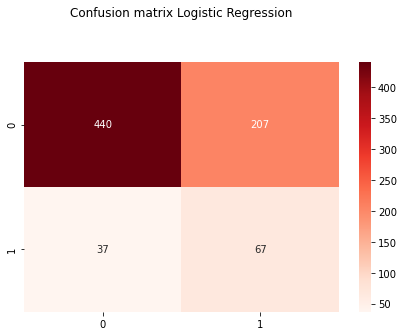

In [68]:
# plotting confusion matrix LogReg

cnf_matrix_log = confusion_matrix(y_test, normalized_df_reg_pred)

sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
#ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression\n', y=1.1)

# 2. Decision Tree

In [69]:
# Decision Tree

#initialize model
dtc_up = DecisionTreeClassifier()

# fit model
dtc_up.fit(X_train, y_train)

normalized_df_dtc_pred = dtc_up.predict(X_test)

# check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
acc = accuracy_score(y_test, normalized_df_dtc_pred)
print(f"The accuracy score for DTC is: {round(acc,3)*100}%")

# f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, normalized_df_dtc_pred)
print(f"The f1 score for DTC is: {round(f1,3)*100}%")

# Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
precision = precision_score(y_test, normalized_df_dtc_pred)
print(f"The precision score for DTC is: {round(precision,3)*100}%")

# recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
recall = recall_score(y_test, normalized_df_dtc_pred)
print(f"The recall score for DTC is: {round(recall,3)*100}%")

The accuracy score for DTC is: 71.5%
The f1 score for DTC is: 49.3%
The precision score for DTC is: 32.7%
The recall score for DTC is: 100.0%


Text(0.5, 1.1, 'Confusion matrix Decision Tree\n')

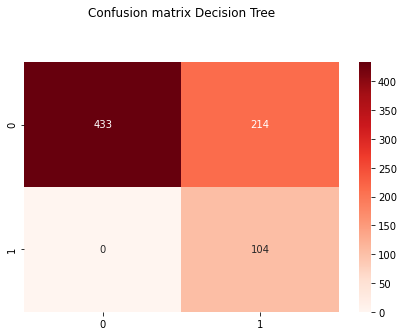

In [70]:
cnf_matrix_dtc = confusion_matrix(y_test, normalized_df_dtc_pred)

sns.heatmap(pd.DataFrame(cnf_matrix_dtc), annot=True,cmap="Reds" , fmt='g')
#ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Decision Tree\n', y=1.1)

# 3. KNN

In [71]:
# KNN Model

#initialize model
knn = KNeighborsClassifier(n_neighbors = 2)

#fit model
knn.fit(X_train, y_train)

# prediction = knn.predict(x_test)
normalized_df_knn_pred = knn.predict(X_test)


# check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
acc = accuracy_score(y_test, normalized_df_knn_pred)
print(f"The accuracy score for KNN is: {round(acc,3)*100}%")

# f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, normalized_df_knn_pred)
print(f"The f1 score for KNN is: {round(f1,3)*100}%")

# Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
precision = precision_score(y_test, normalized_df_knn_pred)
print(f"The precision score for KNN is: {round(precision,3)*100}%")

# recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
recall = recall_score(y_test, normalized_df_knn_pred)
print(f"The recall score for KNN is: {round(recall,3)*100}%")

The accuracy score for KNN is: 81.2%
The f1 score for KNN is: 45.1%
The precision score for KNN is: 37.9%
The recall score for KNN is: 55.800000000000004%


In [72]:
# Check overfit of the KNN model
# accuracy test and train
acc_test = knn.score(X_test, y_test)
print("The accuracy score of the test data is: ",acc_test*100,"%")
acc_train = knn.score(X_train, y_train)
print("The accuracy score of the training data is: ",round(acc_train*100,2),"%")

The accuracy score of the test data is:  81.22503328894807 %
The accuracy score of the training data is:  77.99 %


Result: The KNN model has the highest accuracy score
The scores for test and training data for the KNN model are similar. Therefore we do not expect the model to overfit.

In [73]:
# Perform cross validation
'''Cross Validation is used to assess the predictive performance of the models and and to judge 
how they perform outside the sample to a new data set'''

cv_results = cross_val_score(knn, X, y, cv=5) 

print ("Cross-validated scores:", cv_results)
print("The Accuracy of Model with Cross Validation is: {0:.2f}%".format(cv_results.mean() * 100))

Cross-validated scores: [0.84021305 0.83333333 0.836      0.83866667 0.82666667]
The Accuracy of Model with Cross Validation is: 83.50%


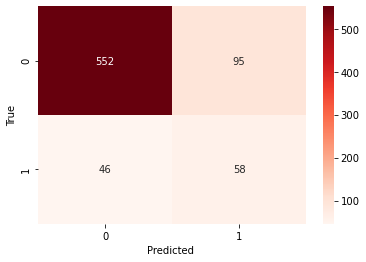

In [74]:
# plotting confusion matrix KNN

cnf_matrix_knn = confusion_matrix(y_test, normalized_df_knn_pred)

ax= plt.subplot()
sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True,cmap="Reds" , fmt='g')

ax.set_xlabel('Predicted ');ax.set_ylabel('True'); 

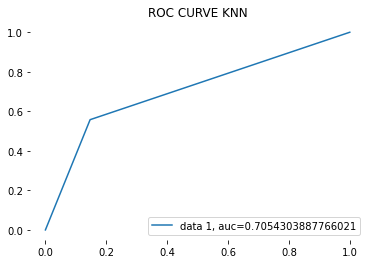

The score for the AUC ROC Curve is: 70.5%


In [75]:
# AU ROC CURVE KNN
'''the AUC ROC Curve is a measure of performance based on plotting the true positive and false positive rate 
and calculating the area under that curve.The closer the score to 1 the better the algorithm's ability to 
distinguish between the two outcome classes.'''

fpr, tpr, _ = roc_curve(y_test, normalized_df_knn_pred)
auc = roc_auc_score(y_test, normalized_df_knn_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.box(False)
plt.title ('ROC CURVE KNN')
plt.show()

print(f"The score for the AUC ROC Curve is: {round(auc,3)*100}%")